In [59]:
import pandas as pd
df = pd.read_csv('customer_churn_dataset.csv')

# Data overview

In [60]:
# Show first 5 rows
print("Head",df.head())
# Show the shape of the DataFrame
print("shape:", df.shape)
# Show last 5 rows
print("Tail",df.tail())
# Display summary statistics
print("Describe",df.describe())
# Display information about the DataFrame
print("Info",df.info())
# Display 
print("Is Null",df.isnull().sum())
# Display number of unique values in each column
print("Nunique",df.nunique())

Head    customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract

# Data Manuplation

In [61]:
# Fix TotalCharges
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].mean())

In [62]:
df["TotalCharges"] = df["TotalCharges"].fillna(df["TotalCharges"].median())
df.fillna({"TotalCharges": df["TotalCharges"].median()}, inplace=True)



In [63]:
# convert 'Churn' column to binary
df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})

In [64]:
# Drop customerID column
df = df.drop('customerID', axis=1)

In [65]:
#Identify categorical columns (CatBoost needs this)
cat_cols = df.select_dtypes(include='object').columns.tolist()

# STEP 3 Train/Test Split

In [66]:
from sklearn.model_selection import train_test_split

X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# STEP 4 — Train CatBoost Model (no encoding needed)

In [67]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=8,
    loss_function='Logloss',
    eval_metric='AUC',
    verbose=100
)

model.fit(
    X_train, y_train,
    cat_features=cat_cols,
    eval_set=(X_test, y_test)
)


0:	test: 0.8282811	best: 0.8282811 (0)	total: 197ms	remaining: 1m 38s
100:	test: 0.8638711	best: 0.8653229 (57)	total: 7.9s	remaining: 31.2s
200:	test: 0.8640639	best: 0.8653229 (57)	total: 14s	remaining: 20.8s
300:	test: 0.8628541	best: 0.8653229 (57)	total: 20.8s	remaining: 13.7s
400:	test: 0.8615072	best: 0.8653229 (57)	total: 27.8s	remaining: 6.86s
499:	test: 0.8592946	best: 0.8653229 (57)	total: 34.5s	remaining: 0us

bestTest = 0.8653229062
bestIteration = 57

Shrink model to first 58 iterations.


#✅ STEP 5 — Evaluate the Model

In [68]:

from sklearn.metrics import classification_report, roc_auc_score

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))


              precision    recall  f1-score   support

           0       0.85      0.91      0.88      1036
           1       0.68      0.55      0.61       373

    accuracy                           0.81      1409
   macro avg       0.76      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409

ROC-AUC: 0.8653229062076246


In [69]:
from sklearn.metrics import accuracy_score

probs = model.predict_proba(X_test)[:,1]

best_acc = 0
best_t = 0

for t in [x/100 for x in range(1,100)]:
    pred = (probs >= t).astype(int)
    acc = accuracy_score(y_test, pred)
    if acc > best_acc:
        best_acc = acc
        best_t = t

print("Best Threshold:", best_t, "Accuracy:", best_acc)


Best Threshold: 0.44 Accuracy: 0.8246983676366217


In [70]:
import numpy as np
from sklearn.metrics import classification_report

y_prob = model.predict_proba(X_test)[:, 1]

threshold = 0.35
y_pred_thresh = (y_prob >= threshold).astype(int)

print(classification_report(y_test, y_pred_thresh))


              precision    recall  f1-score   support

           0       0.90      0.82      0.86      1036
           1       0.60      0.75      0.67       373

    accuracy                           0.80      1409
   macro avg       0.75      0.79      0.76      1409
weighted avg       0.82      0.80      0.81      1409



# STEP 5 — Data Visulization

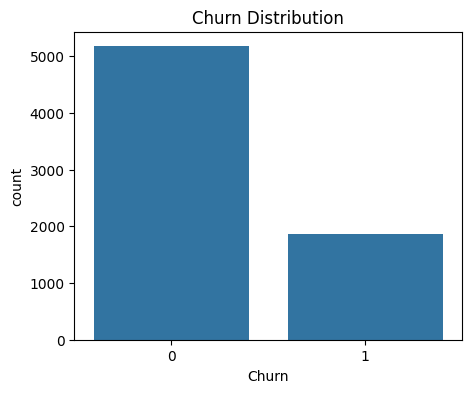

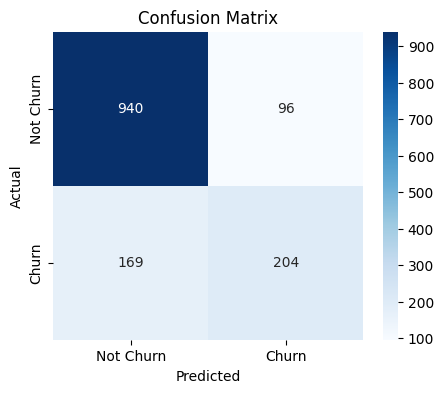

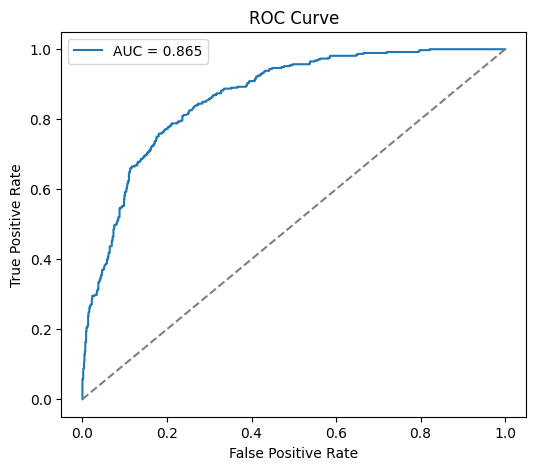

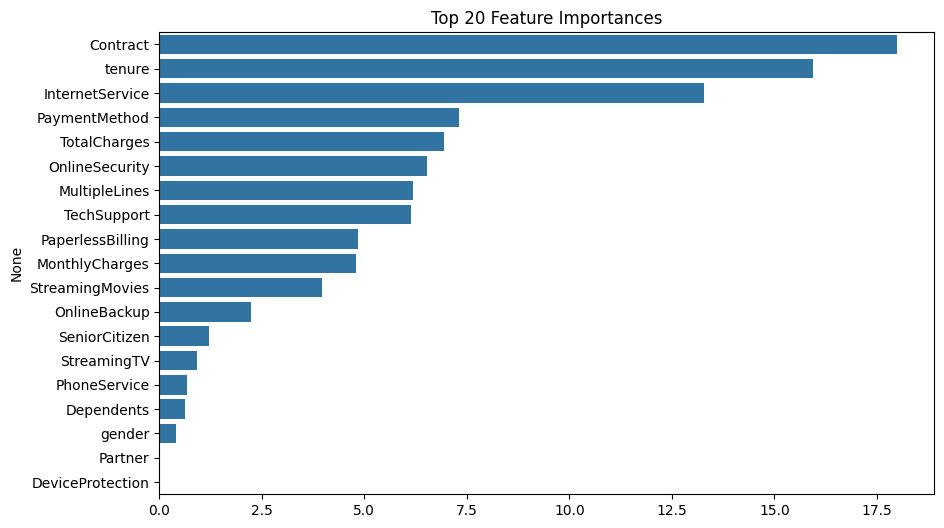

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      1036
           1       0.68      0.55      0.61       373

    accuracy                           0.81      1409
   macro avg       0.76      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409



In [71]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report

# 1) Churn distribution
plt.figure(figsize=(5,4))
sns.countplot(x='Churn', data=df)
plt.title('Churn Distribution')
plt.show()

# 2) Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Churn','Churn'], yticklabels=['Not Churn','Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 3) ROC Curve
y_prob = model.predict_proba(X_test)[:,1]  # replace 'model' with your trained classifier
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0,1], [0,1], '--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# 4) Feature Importance (if RandomForest or XGBoost)
try:
    importances = model.feature_importances_
    feat_imp = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)[:20]
    plt.figure(figsize=(10,6))
    sns.barplot(x=feat_imp.values, y=feat_imp.index)
    plt.title("Top 20 Feature Importances")
    plt.show()
except:
    print("Feature importance not available for this model.")

# 5) Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))


In [72]:
# Save cleaned data
df.to_csv("telco_cleaned.csv", index=False)
print("Saved cleaned Telco dataset for Power BI")

Saved cleaned Telco dataset for Power BI
